<a id="top_section"></a>
# Introduction

When I started doing this analysis my main goal was getting experience. I'm still learning and trying to improve my skills, so there might be some areas can be improved.


### My main objectives on this project are:

* Explorating and visualising the data, trying to get some insights about our dataset
* Getting data in better shape by feature engineering to help us in building better models
* Building and tuning couple regression models to get some stable results on predicting Titanic disaster outcome

### In this notebook we are going to try explore the data we have and going try answer questions like:

- What is the survival rate for specific groups?
- Is there any relation between given info of passengers and their survival?
- Was women and children first policy in order?
- Having higher social status in helped people getting in life boats?
- The mustering order from captain was highly dependent on the class of the passengers, can we spot this  effect between pclass and the survival rates?
- What are the effects of being alone or with family?

- Can we predict if a passenger survived from the disaster with using machine learning techniques?
- What can our predictions achieve with different approaches?
- How are the ROC and Learning curves looks like for different models and can they help with selecting right one?
- If we decrease dimensionality by feature selection and extraction, what would be the effects on the models?
- How are the decision regions looks like for different estimators?



#### If you liked this kernel feel free to upvote and leave feedback, thanks!


<a id="toc_section"></a>
## Table of Contents
* [Introduction](#top_section)
    - [Well... What do we have here?](#section1)
* [Exploring the Data](#section2)
    - [Categorical Features](#section3)
    - [Numerical Features](#section4)
    - [Missing Values](#section5)    
* [Building the Feature Engineering Machine](#section6)
    - [Data Merger](#section7)
    - [Family Assembler](#section8)
    - [Family Survival Detector](#section9)   
    - [Title Extractor](#section10)
    - [Title Encoder](#section11)
    - [Age Filler](#section12)
    - [Age Grouper](#section13)
    - [Fare Imputer](#section14)
    - [Fare Encoder](#section15)
    - [Scaler](#section16)
    - [Embarked Processor](#section17)
    - [Deck Finder](#section18)
    - [Gender Mapper](#section19)
    - [Pclass Sorter](#section20)
    - [Ticket Cleaner](#section21)
    - [Housekeeping](#section22)
    - [Feeding the Machine](#section23)
* [Double Check](#section24)
    - [Correlation Matrix](#section25)
* [Modelling](#section26)
    - [Model Selection](#section27)
    - [Cross-Validate Models](#section28)
    - [Model Results](#section29)
    - [ROC'S of the Models](#section30)
    - [Learning Curves of the Models](#section31)
* [Feature Selection](#section31.1)
    - [Feature Importances](#section32)
    - [Decision Trees](#section33)    
    - [Feature Selection by Recursive Feature Elimination](#section34)
    - [Dimension Reduction by Principal Component Analysis](#section35)
    - [Reduced Dimension Model Results with Cross-Validation](#sectioncv)
* [Plotting Decision Boundaries](#section36)
* [Plotting Decision Regions](#section37)
* [Submission & Some Last Words](#sectionlst)




In [2]:
# Importing neccesary packages.

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

#

from scipy import interp
import math
from scipy.stats import norm
from scipy import stats

#

import warnings
warnings.filterwarnings('ignore') # Disabling warnimgs for clearer outputs
pd.options.display.max_columns = 50 # Pandas option to increase max number of columns to display
plt.style.use('ggplot') # Setting default plot style


<a id="section1"></a>
# Well... What do we have here?

Ok we have two sets(train and test) data and in total 1301 observations 11 features. Our target is Survived column which is not present on the test set(duh!)... With basic inspection I'd say 'PassengerId' has effect on survival, but... Maybe we can use it on feature engineering part? For the rest we gonna inspect them individually soon but  generally speaking they look mostly categorical data with some continuous values like Fare and Age.

I'm going to use different sets of variables for visualizing and feature engineering so let's start with assigning visualizing ones. I'm also saving idx variable for future use.

### [Back To Table of Contents](#toc_section)


In [3]:
# Read train and test data from csv files for visualization
v_train = pd.read_csv('./titanic/train.csv')
v_test = pd.read_csv('./titanic/test.csv')
idx = len(v_train)

In [4]:
# Checking train and test sets
display(v_train.sample(3))
display(v_test.sample(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
690,691,1,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,B20,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
351,1243,2,"Stokes, Mr. Philip Joseph",male,25.0,0,0,F.C.C. 13540,10.5000,NaN,S
86,978,3,"Barry, Miss. Julia",female,27.0,0,0,330844,7.8792,NaN,Q
195,1087,3,"Karlsson, Mr. Julius Konrad Eugen",male,33.0,0,0,347465,7.8542,NaN,S


In [5]:
# Merging visualization datasets.
v_train.drop('PassengerId', axis=1, inplace=True)
v_test.drop('PassengerId', axis=1, inplace=True)
v_merged = pd.concat([v_train, v_test], sort=False).reset_index(drop=True)

In [6]:
# Checking merged shape
display(v_merged.shape)

(1309, 11)

In [7]:
# Checking features and target columns
display(v_merged.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
# Checking dtypes
display(v_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


None

<a id="section2"></a>
# Exploring the Data

<a id="section3"></a>
## Categorical Features

- **Survived:** Indicates that if particular passenger survived(1) or not(0)
- **Pclass:** Shows classes for the passenger, 1 for first, 2 for second and 3 for third.
- **Sex:** Indicates gender of the passenger. Might be crucial indicator for our model since historical records show women were first to save in ship accidents.
- **SibSp:** The number of siblings and spouses on the ship, might be useful for extracting family ties.
- **Parch:** The number of parents and children on the ship, migt have similar use with SibSp.
- **Embarked:** Flag for the where the passenger embarked from, C for Cherbourg, Q for Queenstown, S for Southampton

### [Back To Table of Contents](#toc_section)

In [54]:
# Selecting categorical data for univariate analysis
cats = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']


def plotFrequency(cats):
    #"A plot for visualize categorical data, showing both absolute and relative frequencies"
    fig, axes = plt.subplots(math.ceil(len(cats) / 3), 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        if cat == 'Survived':
            total = float(len(v_train[cat]))
        else:
            total = float(len(v_merged[cat]))
        sns.countplot(v_merged[cat], palette='plasma', ax=ax)

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

        plt.ylabel('Count', fontsize=15, weight='bold')


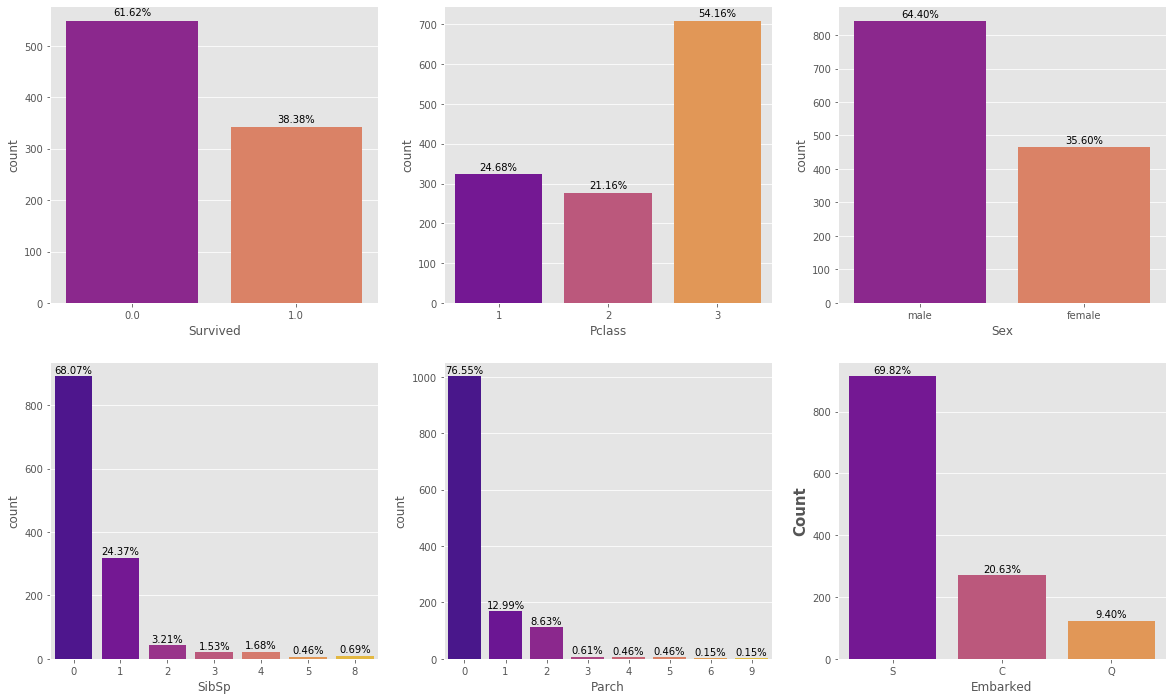

In [10]:
plotFrequency(cats)

**Observations:**

- Sadly most of the train set passengers are not survived, around 62 percent.
- While having highest portion of the passengers on the ship, 3rd class also having highest casuality ratio. Meanwhile first class have more survival rate. So this kinda confirms our hypothesis that mustering orders from captain (1>2>3) might have effect on survival.
- Again most of the passengers on the ship are males(around two third of the passengers) they also have much higher ratio of casualities too. This confirms women part of the "Women and children first policy" had an effect in our Titanic case.
- Most of our passengers are travelling alone, they also have high casuality rate. So being married or with family has some positive effect on survival?
- Most of the passenger are embarked from Southampton. Survival rates differ between ports but I'm not sure if it's important observation or just random. We can relate this to families, groups to get something out of it or just use as it is.

Ok these are my rough observations from inspecting some categorical data, let's continue with numerical ones...

### [Back To Table of Contents](#toc_section)

In [11]:
def plotsurvival(cats, data):
    #"A plot for bivariate analysis"
    fig, axes = plt.subplots(math.ceil(len(cats) / 3), 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        if cat == 'Survived':
            sns.countplot(v_train[cat], palette='plasma', ax=ax)

        else:

            sns.countplot(x=cat,
                          data=data,
                          hue='Survived',
                          palette='plasma',
                          ax=ax)
            ax.legend(title='Survived?',
                      loc='upper right',
                      labels=['No', 'Yes'])

        plt.ylabel('Count', fontsize=15, weight='bold')


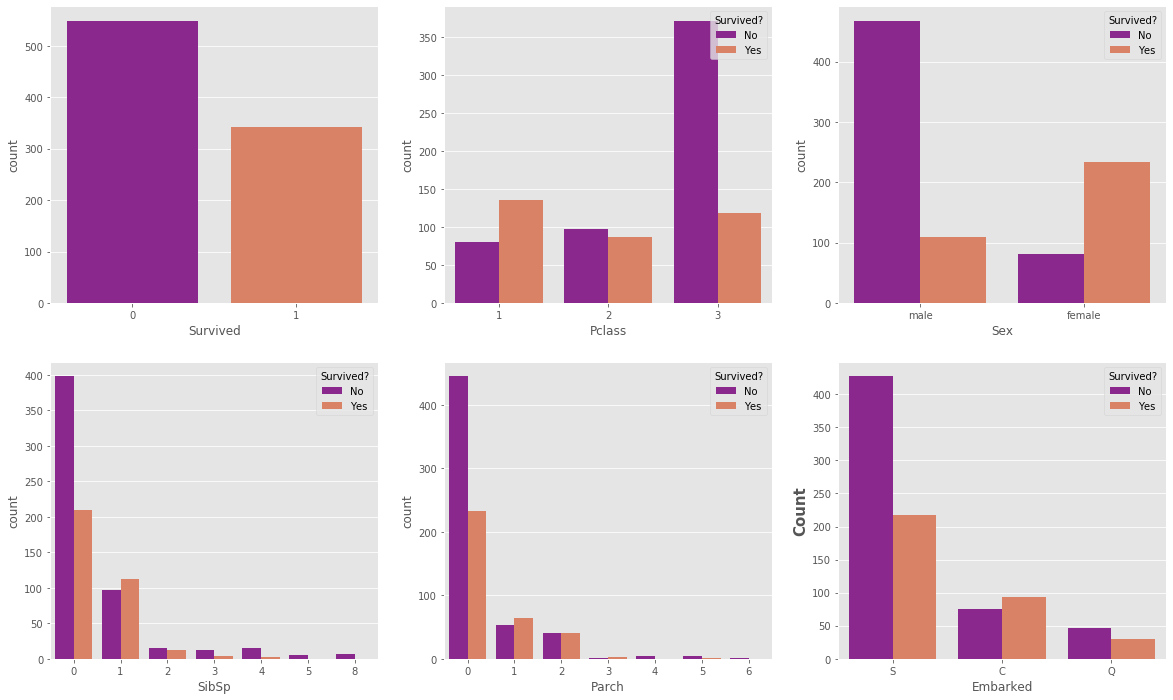

In [12]:
plotsurvival(cats, v_train)

<a id="section4"></a>
## Numerical Features

- **Age:** Well an obvious feature that indicates age of the passenger.
- **Fare:** Again obvious one that shows amount of the money spent on the ticket.

**Observations:**

- Seems our Age values distrubuted well, little right skewed with high number of young adults. With the median age of 28 there are little bit of ouliers but things look ordinal.

- Fare distrubution doesn't look good, not fitting normal distrubution at all. While most of the passenger fares are below 30, there are some crazy outliers lying there like 500+ spent on tickets. We might need to scale our data for the models or assigning bins to categorize them to get better results...

### [Back To Table of Contents](#toc_section)

In [13]:
def plot_3chart(df, feature):
    import matplotlib.gridspec as gridspec
    from matplotlib.ticker import MaxNLocator
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    # creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Probability Plot')
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{feature}', fontsize=24)

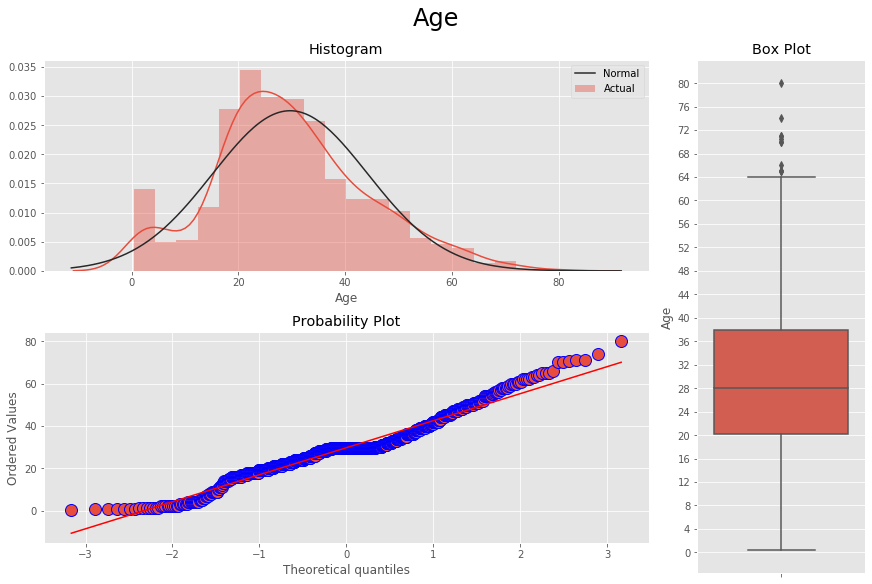

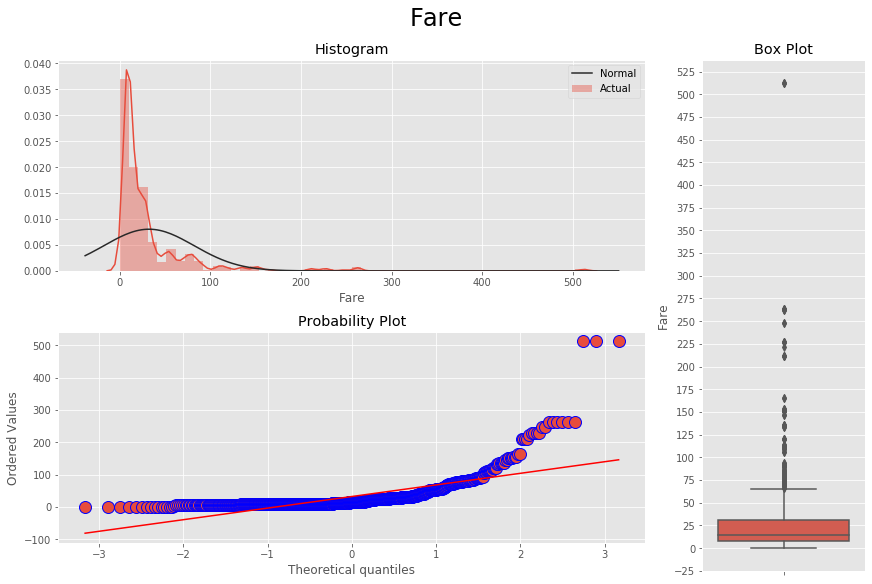

In [14]:
plot_3chart(v_train, 'Age')
plot_3chart(v_train, 'Fare')

**It seems, fare and age has no strong linear relation with survival outcomes even with Spearman correlation. We're going to bin these variables to get better results...**

In [15]:
# Listing most related continious values to target.
train_corr = v_train[['Survived', 'Age', 'Fare'
                      ]].corr(method='spearman').abs().unstack().sort_values(
                          kind='quicksort', ascending=False).reset_index()
train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
                  inplace=True)
train_corr[(train_corr['Feature A'] == 'Survived')].style.background_gradient(
    cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
2,Survived,Survived,1.000000
4,Survived,Fare,0.323736
8,Survived,Age,0.052565


<a id="section5"></a>
## Missing Values

On both datasets Cabin feature is missing a lot, it looks this feature not useful for modelling but we might give it a chance with feature engineering later.

Again, Age feature has many missing values, we can impute them with some logical way to use later...

There are little number of missing values on Embarked and Fare, I think we can impute them without taking much risk.

### [Back To Table of Contents](#toc_section)

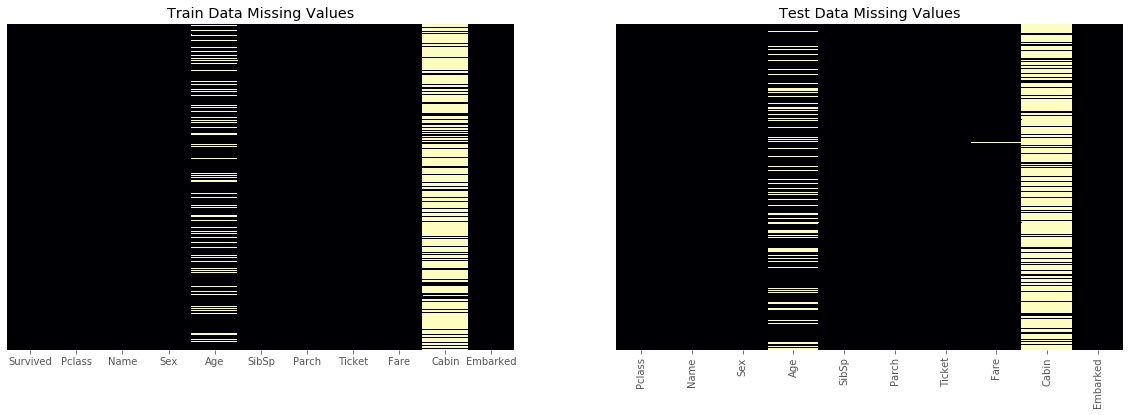

In [16]:
# Detecting missing data

fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.heatmap(v_train.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[0])
sns.heatmap(v_test.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

plt.xticks(rotation=90)
plt.show()

<a id="section6"></a>
# Building the Feature Engineering Machine

Here comes to part where we are going to play with the data we have. I wanted to build functions instead of moving one by one, I feel like with this way I can change my build up for the model more easily. Since there are some changes might get better results but there are some changes might badly effect outcome of the model by increasing complexity. This is a trial and error process so with this approach I feel like I can control them easily.

I called this part machine but if you are more traditional you can say this is our toolbox too :)

### [Back To Table of Contents](#toc_section)

In [17]:
def status(feature):
    print('Processing', feature, ': DONE')
    print(f'Shape after processing {combined.shape}')
    print('*' * 40)

<a id="section7"></a>
## Data Merger

- This function merges our train and test sets so we can transform them together.

### [Back To Table of Contents](#toc_section)

In [18]:
def get_combined_data():
    # Reading train data
    train = pd.read_csv('./titanic/train.csv')

    # Reading test data
    test = pd.read_csv('./titanic/test.csv')

    # extracting the targets from the training data
    targets = train.Survived

    # Merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.reset_index(inplace=True, drop=True)

    return combined

<a id="section8"></a>
## Family Assembler

- Combining Parch and SibSp and passenger can give us new indicator that shows how big the family that person belongs to. 

- Since being alone might have an effect on survival we creating another feature for it.

- We can also categorize family size manually 

### [Back To Table of Contents](#toc_section)

In [19]:
def process_family():

    global combined
    # Introducing a new feature : The size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

    # Introducing another feature based on the family size
    combined['Alone'] = combined['FamilySize'].map(lambda s: 1
                                                   if s == 1 else 0)

    # These two below are optional, it didn't help with the model...
    #combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    #combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

    status('Family')
    return combined

<a id="section9"></a>
## Family Survival Detector

On this approach I got insprided from S.Xu's work with families. The family information is extracted from name, fare and ticket number through examing of the data. I found this feature pretty useful on models.

### [Back To Table of Contents](#toc_section)

In [20]:
def family_survival():
    global combined

    # A function working on family survival rate using last names and ticket features

    # Extracting surnames
    combined['Last_Name'] = combined['Name'].apply(
        lambda x: str.split(x, ",")[0])

    # Adding new feature: 'Survived'
    default_survival_rate = 0.5
    combined['Family_Survival'] = default_survival_rate

    for grp, grp_df in combined[[
            'Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
            'SibSp', 'Parch', 'Age', 'Cabin'
    ]].groupby(['Last_Name', 'Fare']):

        if (len(grp_df) != 1):
            # A Family group is found.
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    combined.loc[combined['PassengerId'] ==
                                 passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    combined.loc[combined['PassengerId'] ==
                                 passID, 'Family_Survival'] = 0

    for _, grp_df in combined.groupby('Ticket'):
        if (len(grp_df) != 1):
            for ind, row in grp_df.iterrows():
                if (row['Family_Survival'] == 0) | (
                        row['Family_Survival'] == 0.5):
                    smax = grp_df.drop(ind)['Survived'].max()
                    smin = grp_df.drop(ind)['Survived'].min()
                    passID = row['PassengerId']
                    if (smax == 1.0):
                        combined.loc[combined['PassengerId'] ==
                                     passID, 'Family_Survival'] = 1
                    elif (smin == 0.0):
                        combined.loc[combined['PassengerId'] ==
                                     passID, 'Family_Survival'] = 0

    status('FamilySurvival')
    return combined

<a id="section10"></a>
## Title Extractor

This function extracts prefixes from passenger names and groups them in more generalized titles. We know male survival is low but we also know women and children first, right? So we can extract 'Master' title which is given for young males and their survival ratio might differ.

### [Back To Table of Contents](#toc_section)

In [21]:
def get_titles():

    title_dictionary = {
        'Capt': 'Dr/Clergy/Mil',
        'Col': 'Dr/Clergy/Mil',
        'Major': 'Dr/Clergy/Mil',
        'Jonkheer': 'Honorific',
        'Don': 'Honorific',
        'Dona': 'Honorific',
        'Sir': 'Honorific',
        'Dr': 'Dr/Clergy/Mil',
        'Rev': 'Dr/Clergy/Mil',
        'the Countess': 'Honorific',
        'Mme': 'Mrs',
        'Mlle': 'Miss',
        'Ms': 'Mrs',
        'Mr': 'Mr',
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Master': 'Master',
        'Lady': 'Honorific'
    }

    # Extract the title from names
    combined['Title'] = combined['Name'].map(
        lambda name: name.split(',')[1].split('.')[0].strip())

    # Mapping titles
    combined['Title'] = combined.Title.map(title_dictionary)
    status('Title')
    return combined

<a id="section11"></a>
## Title Encoder

This function is for getting dummy variables for titles, might or might not use it.

### [Back To Table of Contents](#toc_section)

In [22]:
def process_names():
    global combined
    # Cleaning the Name variable
    combined.drop('Name', axis=1, inplace=True)

    # Encoding names as dummy variables
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)

    # Removing the title variable after getting dummies
    combined.drop('Title', axis=1, inplace=True)

    status('names')
    return combined

<a id="section12"></a>
## Age Filler

This function is for filling missing values in Age feature using most revelant features. Tried different approaches(like giving random value etc.) but they don't change model performance much so I selected simplier one.

### [Back To Table of Contents](#toc_section)

In [23]:
def process_age():
    global combined
    # A function that fills the missing values of the Age variable
    combined['Age'] = combined.groupby(
        ['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
    status('Age')
    return combined

<a id="section13"></a>
## Age Grouper

A function for categorizing the age values and setting dummy variables for each one.

Updated this one with the feedback from @Ayaan, replaced old custom grouping with pd.qcut This approach increased our score by 0.005'ish... Thanks for the feedback!

### [Back To Table of Contents](#toc_section)

In [24]:
def age_binner():
    global combined
    # Ranging and grouping Ages
    #bins = [0, 2, 18, 35, 65, np.inf]
    names = ['less2', '2-18', '18-35', '35-65', '65plus']

    #combined['AgeBin'] = pd.cut(combined['Age'], bins, labels=names)
    combined['AgeBin'] = pd.qcut(combined['Age'],q = 5, labels = names)
    age_dummies = pd.get_dummies(combined['AgeBin'], prefix='AgeBin')
    combined = pd.concat([combined, age_dummies], axis=1)
    combined.drop('AgeBin', inplace=True, axis=1)
    combined.drop('Age', inplace=True, axis=1)
    status('Age Bins')
    return combined

<a id="section14"></a>
## Fare Imputer

Again a basic function for filling missing fare values.

### [Back To Table of Contents](#toc_section)

In [25]:
def process_fares():
    global combined

    # Filling missing values in fare

    combined['Fare'] = combined.groupby(
        ['Pclass', 'Sex'])['Fare'].apply(lambda x: x.fillna(x.median()))
    status('fare')
    return combined

<a id="section15"></a>
## Fare Encoder

Since there are multiple outliers I just wanted to group and categorize them. I used historical ticket prices for grouping, maybe using pcut would be better choice but I just went with historical grouping.

### [Back To Table of Contents](#toc_section)

In [26]:
def process_fare_bin(onehot='None'):

    global combined
    # Ranging and grouping Fare using historical data
    bins = [-1, 7.91, 14.454, 31, 99, 250, np.inf]
    names = [0, 1, 2, 3, 4, 5]

    combined['FareBin'] = pd.cut(combined['Fare'], bins,
                                 labels=names).astype('int')
    if onehot == 'yes':
        farebin_dummies = pd.get_dummies(combined['FareBin'], prefix='FareBin')
        combined = pd.concat([combined, farebin_dummies], axis=1)
        combined.drop('FareBin', inplace=True, axis=1)
        combined.drop('Fare', inplace=True, axis=1)
    elif onehot == 'both':
        farebin_dummies = pd.get_dummies(combined['FareBin'], prefix='FareBin')
        combined = pd.concat([combined, farebin_dummies], axis=1)
        combined.drop('FareBin', inplace=True, axis=1)
    else:
        combined.drop('Fare', inplace=True, axis=1)

    status('FareBin')
    return combined

<a id="section16"></a>
## Scaler

Another function for getting rid of outliers in Fare values with using boxcox. I wasn't sure about if I use this or binning, but model did little better at the end with binning.

### [Back To Table of Contents](#toc_section)

In [27]:
def scale_fare():

    # A definition for scaling fare values

    from scipy.stats import skew, boxcox_normmax, norm
    from scipy.special import boxcox1p
    global combined
    combined['Fare'] = boxcox1p(combined['Fare'],
                                boxcox_normmax(combined['Fare'] + 1))
    status('NFareBin')
    return combined

<a id="section17"></a>
## Embarked Processor

A function for filling missing values and then hot encoding for each value.

### [Back To Table of Contents](#toc_section)

In [28]:
def process_embarked():
    global combined
    # Filling missing embarked values with the most frequent one
    combined.Embarked.fillna(combined.Embarked.mode()[0], inplace=True)
    # One hot encoding
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('Embarked')
    return combined

<a id="section18"></a>
## Deck Finder

This approach is trying to find something out of Cabin values and assignin it to newly created Deck column. I tried this approach on models but didn't get much, other than adding complexity.

### [Back To Table of Contents](#toc_section)

In [29]:
def process_cabin():
    global combined
    # Replacing missing cabins with M (for Missing)
    combined['Cabin_Informed'] = [
        1 if pd.notnull(cab) else 0 for cab in combined['Cabin']
    ]
    combined.Cabin.fillna('M', inplace=True)

    # Mapping each Cabin value with the cabin letter
    combined['Deck'] = combined['Cabin'].map(lambda c: c[0])

    combined['Deck'].replace('T', 'A', inplace=True)

    # One hot encoding ...
    cabin_dummies = pd.get_dummies(combined['Deck'], prefix='Deck')
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    combined.drop('Deck', axis=1, inplace=True)
    status('Cabin')
    return combined

<a id="section19"></a>
## Gender Mapper

This is a function for assigning numerical values for each gender.

### [Back To Table of Contents](#toc_section)

In [30]:
def process_sex():
    global combined
    # Mapping string values with numerical ones
    combined['Sex'] = combined['Sex'].map({'male': 1, 'female': 0})
    status('Sex')
    return combined

<a id="section20"></a>
## Pclass sorter
Again a function for getting dummy variables for passenger classes.

### [Back To Table of Contents](#toc_section)

In [31]:
def process_pclass():

    global combined
    # One hot encoding pclass into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass')

    # Adding dummy variables to main set
    combined = pd.concat([combined, pclass_dummies], axis=1)

    # Removing redundant 'Pclass'
    combined.drop('Pclass', axis=1, inplace=True)

    status('Pclass')
    return combined

<a id="section21"></a>
## Ticket Cleaner

This function extract prefixes from ticket and assign them to specific group based on their prefix. Again I found this approach adding complexity only.

### [Back To Table of Contents](#toc_section)

In [32]:
def process_ticket():

    global combined

    # A function that extracts each prefix of the ticket, returns 'Unknown' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.', '')
        ticket = ticket.replace('/', '')
        ticket = ticket.split()
        ticket = map(lambda t: t.strip(), ticket)
        ticket = list(filter(lambda t: not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else:
            return 'Unknown'

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

<a id="section22"></a>
## Housekeeping

This function is for cleaning the redundant features after extracting useful information from them. The cabin, passengerId, last name, ticket and ofc our target survived is going to be dropped. These features did their job on feature engineering and we can leave them in peace now.

### [Back To Table of Contents](#toc_section)

In [33]:
def dropper():
    global combined

    combined.drop('Cabin', axis=1, inplace=True)
    combined.drop('PassengerId', inplace=True, axis=1)
    combined.drop('Last_Name', inplace=True, axis=1)
    combined.drop('Survived', inplace=True, axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    return combined

<a id="section23"></a>
## Feeding the Machine

Ok this is our command room, this is where I control the switches for feature engineering(aka commenting some functions out or combine them :D) Well, this was pretty trial and error methodology for me. Tried couple combinations of feature engineering and tried to find best fit on the models. Here is what I came up with.

### [Back To Table of Contents](#toc_section)

In [34]:
# Executing definitions to process data
combined = get_combined_data()  # For merging train test data
combined = family_survival()  # For creating family survival feature
combined = process_family()  # For creating Family size feature
combined = get_titles()  # For extracting titles
combined = process_names()  # For one hot encoding titles
combined = process_age()  # For imputing missing age values
combined = age_binner()  # For grouping and hot encoding age ranges
combined = process_fares()  # For imputing fares
# For grouping and label encoding fares, can use 'both' for keeping age with dummies or yes for just one hot
combined = process_fare_bin(onehot='no')
# combined =scale_fare() # For scaling age values
combined = process_embarked()  # For imputing embarked and one hot encoding
# combined = process_cabin() # For extracting deck info from cabins
combined = process_sex()  # For label encoding sex
# combined = process_pclass() # For one hot encoding pclass
# combined = process_ticket() # For extracting ticket info
combined = dropper()  # For dropping not needed features
print(
    f'Processed everything. Missing values left: {combined.isna().sum().sum()}'
)

Processing FamilySurvival : DONE
Shape after processing (1309, 14)
****************************************
Processing Family : DONE
Shape after processing (1309, 16)
****************************************
Processing Title : DONE
Shape after processing (1309, 17)
****************************************
Processing names : DONE
Shape after processing (1309, 21)
****************************************
Processing Age : DONE
Shape after processing (1309, 21)
****************************************
Processing Age Bins : DONE
Shape after processing (1309, 25)
****************************************
Processing fare : DONE
Shape after processing (1309, 25)
****************************************
Processing FareBin : DONE
Shape after processing (1309, 25)
****************************************
Processing Embarked : DONE
Shape after processing (1309, 27)
****************************************
Processing Sex : DONE
Shape after processing (1309, 27)
**************************************

<a id="section24"></a>
# Double Check

Ok, this is the part where we're going make sure our data is ready for the modelling. So, let's start with checking how's our data looking. Everyting seems in order...

### [Back To Table of Contents](#toc_section)

In [35]:
# Assigning engineered data to inspection variable.
v_merged = combined.copy()
v_merged['Survived'] = v_train['Survived']
v_merged.head()

,Pclass,Sex,SibSp,Parch,Family_Survival,FamilySize,Alone,Title_Dr/Clergy/Mil,Title_Honorific,Title_Master,Title_Miss,Title_Mr,Title_Mrs,AgeBin_less2,AgeBin_2-18,AgeBin_18-35,AgeBin_35-65,AgeBin_65plus,FareBin,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,1,1,0,0.5,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0.0
1,1,0,1,0,0.5,2,0,0,0,0,0,0,1,0,0,0,1,0,3,1,0,0,1.0
2,3,0,0,0,0.5,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1.0
3,1,0,1,0,0.0,2,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,1,1.0
4,3,1,0,0,0.5,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0.0


In [36]:
v_merged.describe()

,Pclass,Sex,SibSp,Parch,Family_Survival,FamilySize,Alone,Title_Dr/Clergy/Mil,Title_Honorific,Title_Master,Title_Miss,Title_Mr,Title_Mrs,AgeBin_less2,AgeBin_2-18,AgeBin_18-35,AgeBin_35-65,AgeBin_65plus,FareBin,Embarked_C,Embarked_Q,Embarked_S,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,2.294882,0.644003,0.498854,0.385027,0.522918,1.883881,0.603514,0.017571,0.004584,0.046600,0.200153,0.578304,0.152788,0.221543,0.275783,0.108480,0.199389,0.194805,1.576012,0.206264,0.093965,0.699771,0.383838
std,0.837836,0.478997,1.041658,0.865560,0.322230,1.583639,0.489354,0.131435,0.067573,0.210862,0.400267,0.494019,0.359921,0.415444,0.447079,0.311104,0.399694,0.396202,1.265179,0.404777,0.291891,0.458533,0.486592
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,1.000000,0.000000,0.500000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,1.000000,8.000000,9.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


<a id="section25"></a>
## Correlation Matrix

Alright one last table I'm going to check is correlation matrix. So we can spot linear relations between features. Especially the ones which effects survival rate. It seems Sex, the Mr. title and family survival ratio is most related features to survival.

Well... That's it then let's continue with modelling now!

### [Back To Table of Contents](#toc_section)

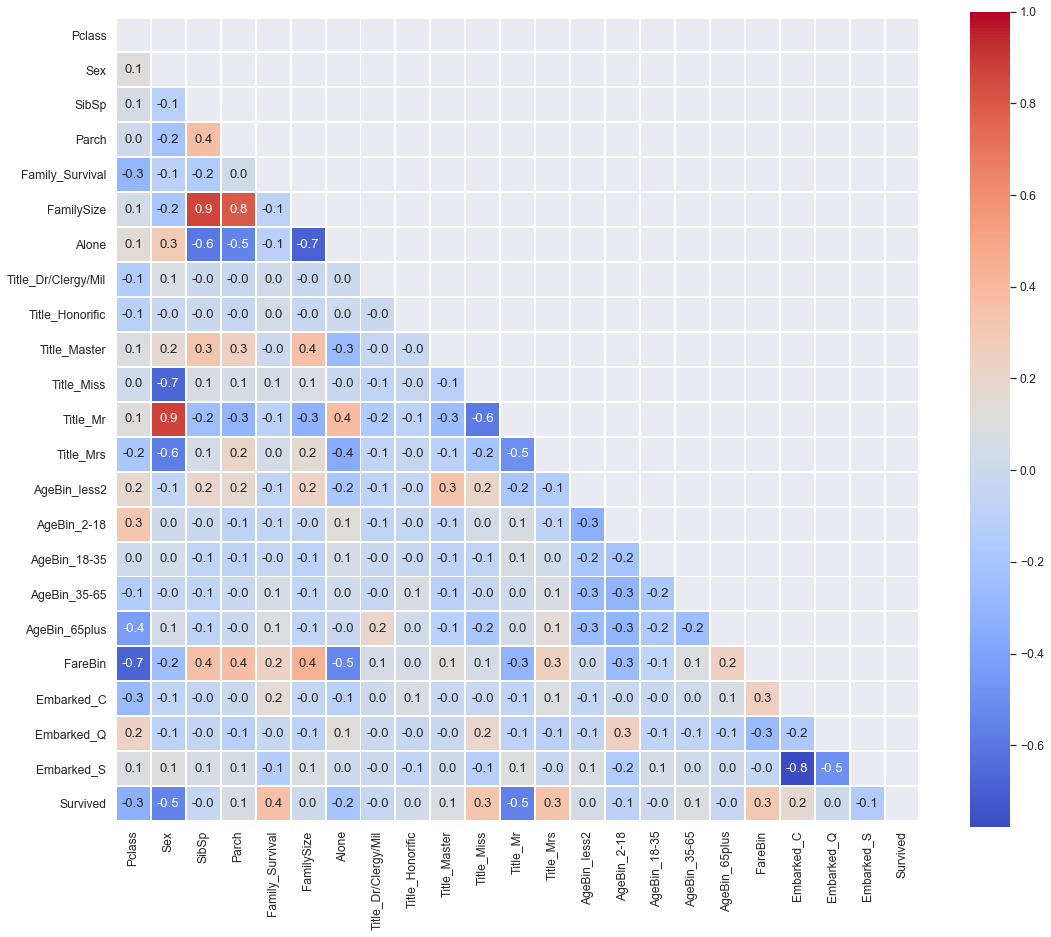

In [37]:
# Display numerical correlations between features on heatmap
sns.set(font_scale=1.1)
correlation_train = v_merged.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1)

plt.show()

<a id="section26"></a>
# Modelling

Since preprocessing done we are ready for training our models. We start with loading packages and splitting our transformed data so we have 22 features and and 891 observations to train our estimators. Our test set has 418 observations to make predictions.

### [Back To Table of Contents](#toc_section)

In [38]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, cross_validate, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import xgboost as xgb
import lightgbm as lgb
from mlxtend.plotting import plot_decision_regions

In [39]:
def recover_train_test_target():
    global combined

    y = pd.read_csv('./titanic/train.csv', usecols=['Survived'])['Survived']
    X = combined.iloc[:idx]
    X_test = combined.iloc[idx:]

    return X, X_test, y


X, X_test, y = recover_train_test_target()

In [40]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_test shape: {X_test.shape}')

X shape: (891, 22)
y shape: (891,)
X_test shape: (418, 22)


<a id="section27"></a>
## Model Selection

I choose couple models to try, mostly ensemble models with boosting but we also have some linear models like  Logistic Regression. I tuned some these models with Optuna but I'm not going to include these meta parts on this notebook.

### [Back To Table of Contents](#toc_section)

In [41]:
# Models

cv = StratifiedKFold(10, shuffle=True, random_state=42)

rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1750,
                            max_depth=7,
                            min_samples_split=6,
                            min_samples_leaf=6,
                            max_features='auto',
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1,
                            verbose=0)

lg = lgb.LGBMClassifier(max_bin=4,
                        num_iterations=550,
                        learning_rate=0.0114,
                        max_depth=3,
                        num_leaves=7,
                        colsample_bytree=0.35,
                        random_state=42,
                        n_jobs=-1)

xg = xgb.XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
)

sv = SVC(probability=True)

logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

gb = GradientBoostingClassifier(random_state=42)

gnb = GaussianNB()

mlp = MLPClassifier(random_state=42)

In [42]:
estimators = [rf, lg, xg, gb, sv, logreg, gnb, mlp]

<a id="section28"></a>
# Cross-Validate Models

We gonna shuffle and fold 10 times to cross validate our models on the training set. With this way we can get some strong indicators to select which estimator is best fit.

### [Back To Table of Contents](#toc_section)

In [43]:
def model_check(X, y, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        #    model_table.loc[row_index, 'MLA Parameters'] = str(est.get_params())

        cv_results = cross_validate(
            est,
            X,
            y,
            cv=cv,
            scoring='accuracy',
            return_train_score=True,
            n_jobs=-1
        )

        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

<a id="section29"></a>
## Model Results

Hmm... It seems our top classifiers are getting similar results and they are mostly ensemble models. Our basic Logistic Regression did pretty well too! Gradient Boosting Classifier seems effected by high variance, we might try to fix it by hyperparameter tuning but I'd say we already have good number of decent estimators so we can continue with them.

### [Back To Table of Contents](#toc_section)

In [44]:
raw_models = model_check(X, y, estimators, cv)
display(raw_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Std,Time
5,LogisticRegression,0.850354,0.849563,0.031212,0.110897
0,RandomForestClassifier,0.857713,0.848452,0.022786,6.064517
2,XGBClassifier,0.856465,0.847328,0.023313,3.327872
1,LGBMClassifier,0.857837,0.846217,0.024247,0.123850
3,GradientBoostingClassifier,0.887517,0.846192,0.023817,0.175675
4,SVC,0.838134,0.832734,0.025545,0.152561
7,MLPClassifier,0.849856,0.832709,0.025622,0.745618
6,GaussianNB,0.810825,0.810312,0.030822,0.002450


In [45]:
# Plotting model performances
def model_barplot(models, bins):
    fig, ax = plt.subplots(figsize=(16, 8))
    g = sns.barplot('Test Accuracy Mean',
                    'Model Name',
                    data=models,
                    palette='plasma',
                    orient='h',
                    **{'xerr': models['Test Std']})
    g.set_xlabel('Test Mean Accuracy')
    g = g.set_title('Cross validation scores')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))

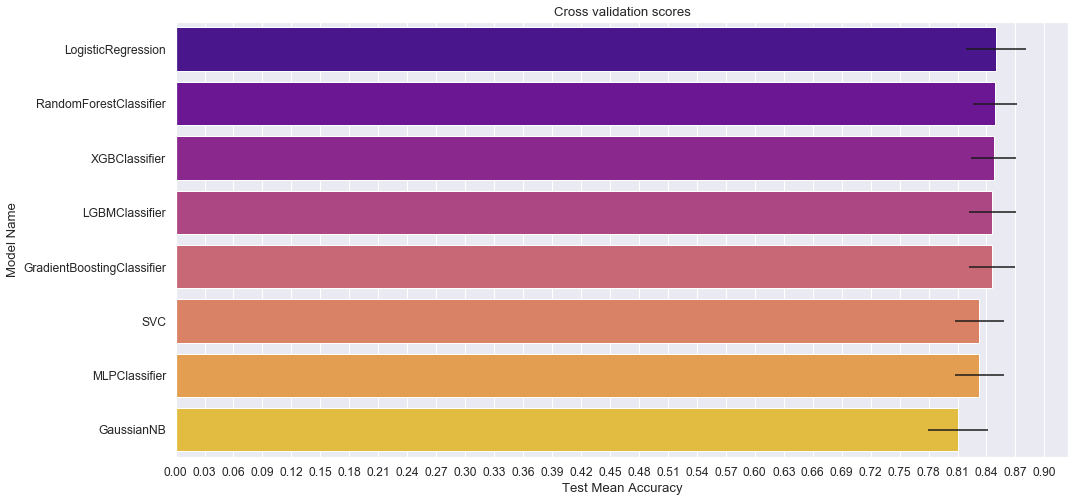

In [46]:
# Plotting model performances
model_barplot(raw_models, 32)

<a id="section30"></a>
# ROC'S of the Models

Ok I'm going with the parts are that not much needed for this competition but I still want to apply them for the sake of learning and improving. Here are the results:

### [Back To Table of Contents](#toc_section)

In [47]:
def m_roc(estimators, cv, X, y):

    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i, (train, test) in enumerate(cv.split(X, y)):
            estimator.fit(X.loc[train], y.loc[train])
            viz = plot_roc_curve(estimator,
                                 X.loc[test],
                                 y.loc[test],
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3,
                                 lw=1,
                                 ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1],
                linestyle='--',
                lw=2,
                color='r',
                label='Chance',
                alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr,
                mean_tpr,
                color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' %
                (mean_auc, std_auc),
                lw=2,
                alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.02, 1.02],
               ylim=[-0.02, 1.02],
               title=f'{estimator.__class__.__name__} ROC')
        ax.legend(loc='lower right', prop={'size': 18})
    plt.show()

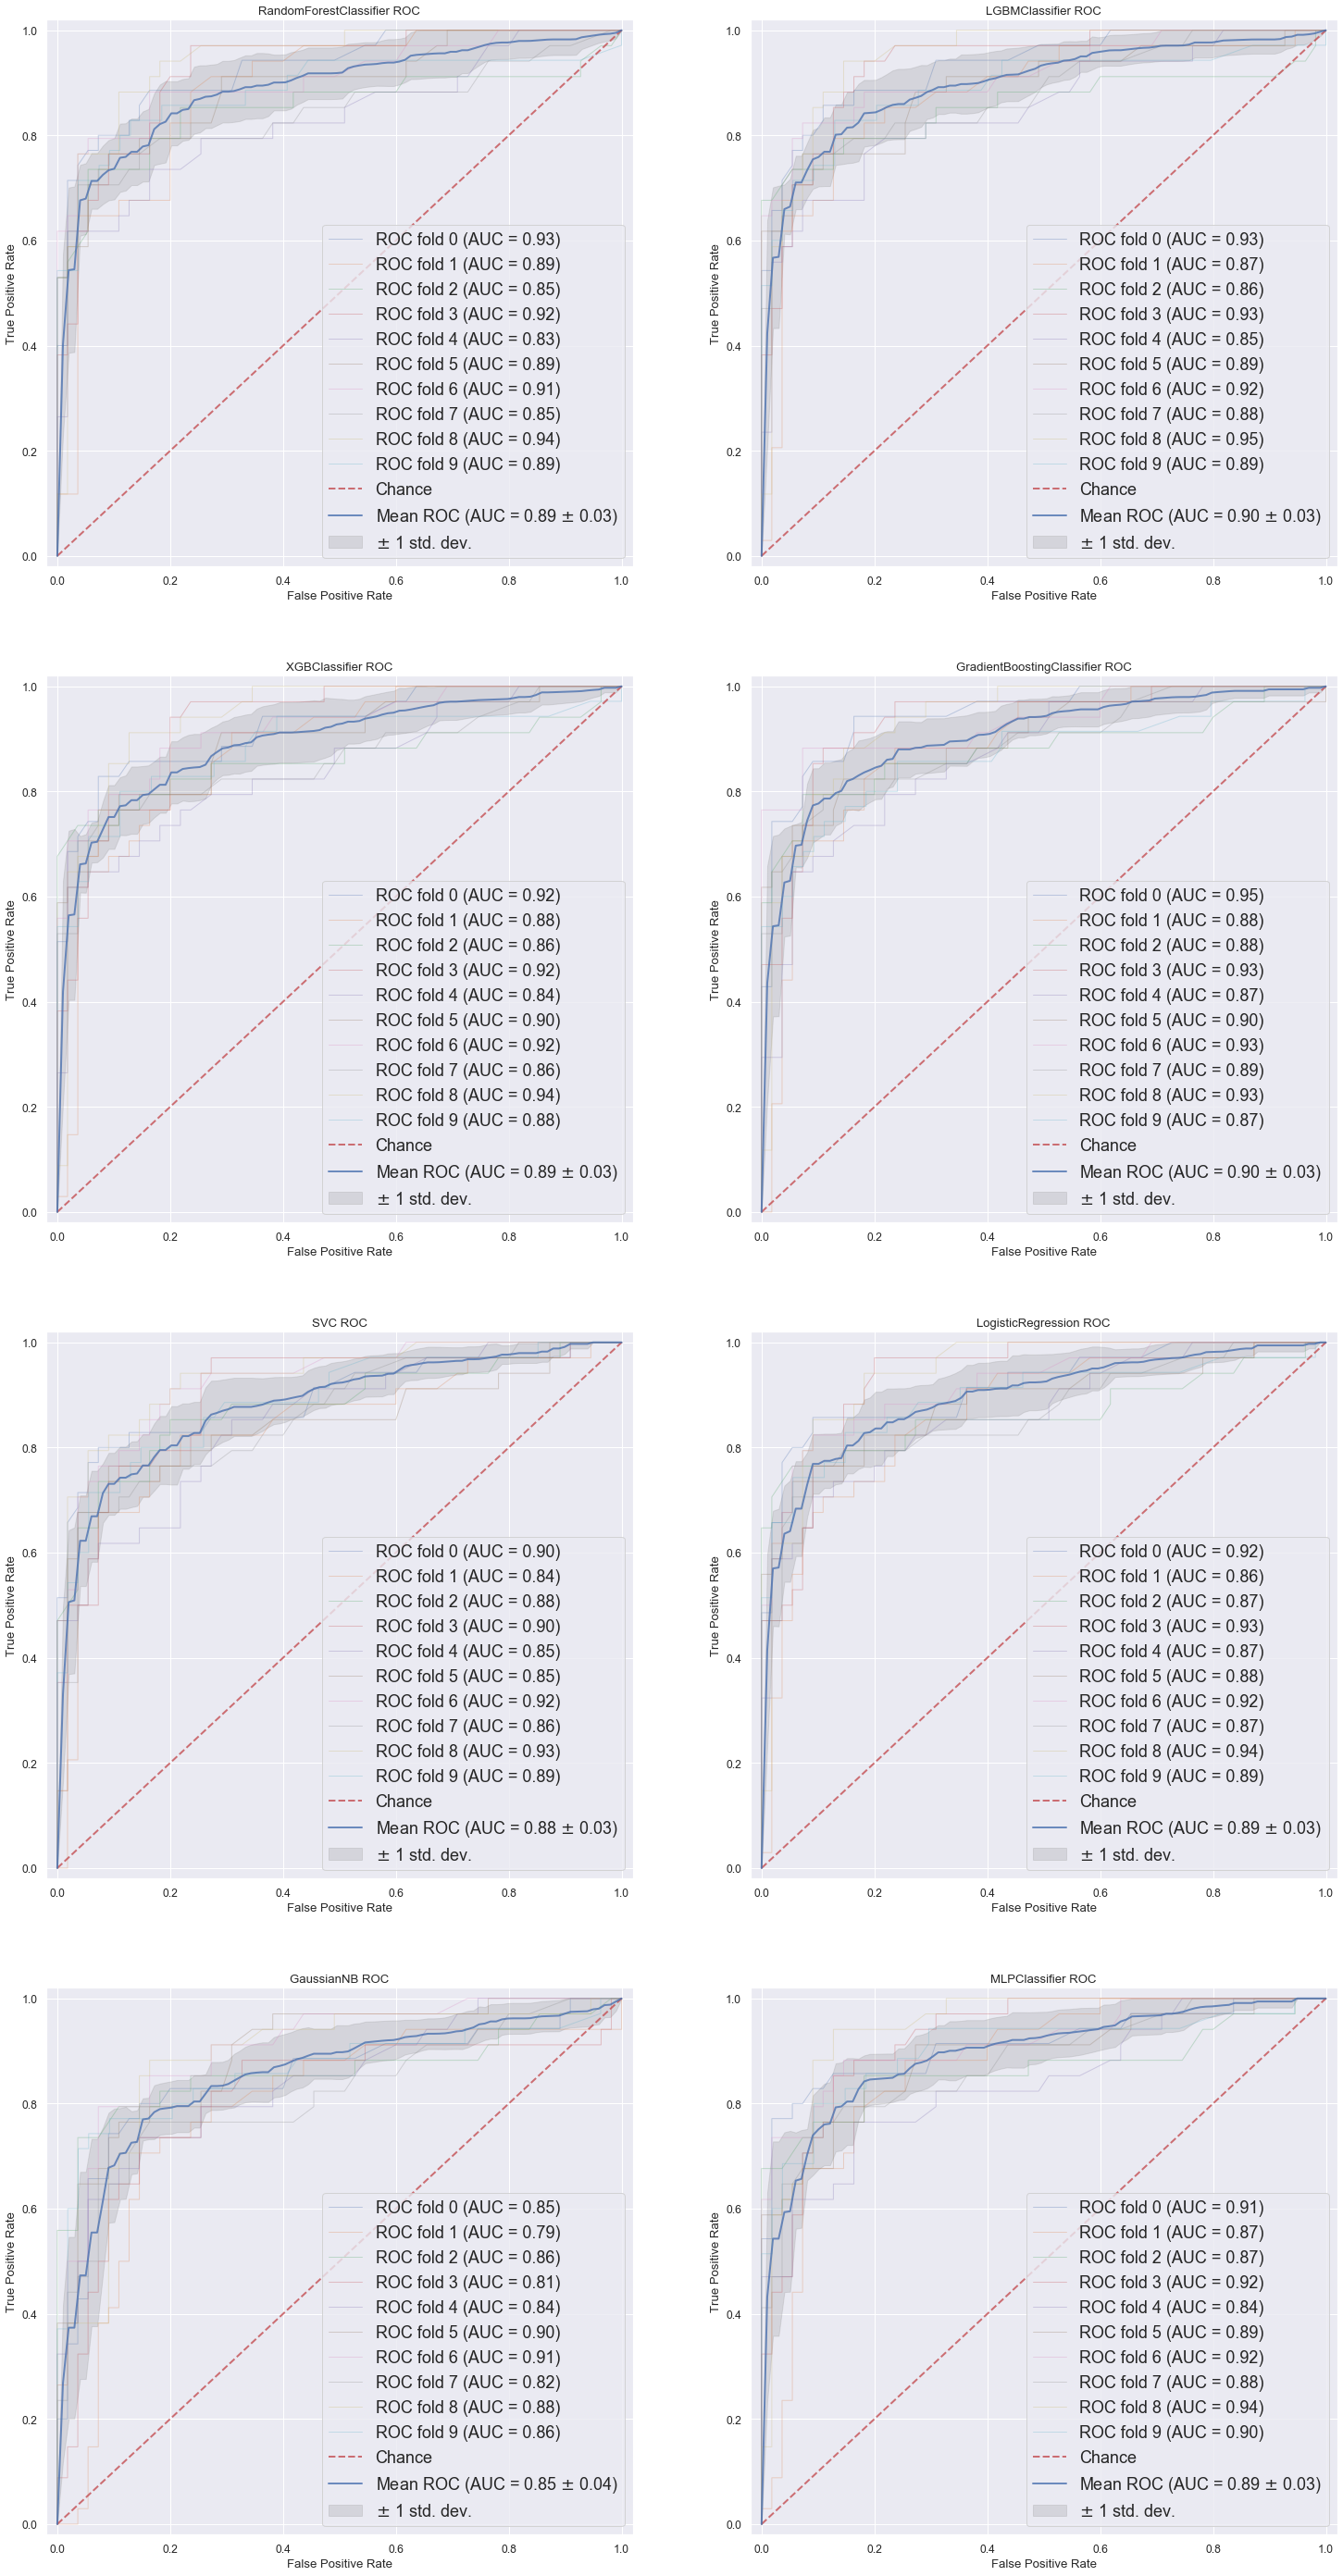

In [48]:
m_roc(estimators, cv, X, y)

<a id="section31"></a>
# Learning Curves of the Models

Learning curves are good indicators for showing if our models are overfitting or underfitting. It's also showing if we need more data or not but it's not the case here since we can't increase our numbers. After inspecting these graphs I'm thinking our top models are looking decent.

### [Back To Table of Contents](#toc_section)

In [49]:
def plot_learning_curve(estimators,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        ax.set_title(f'{estimator.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.show()

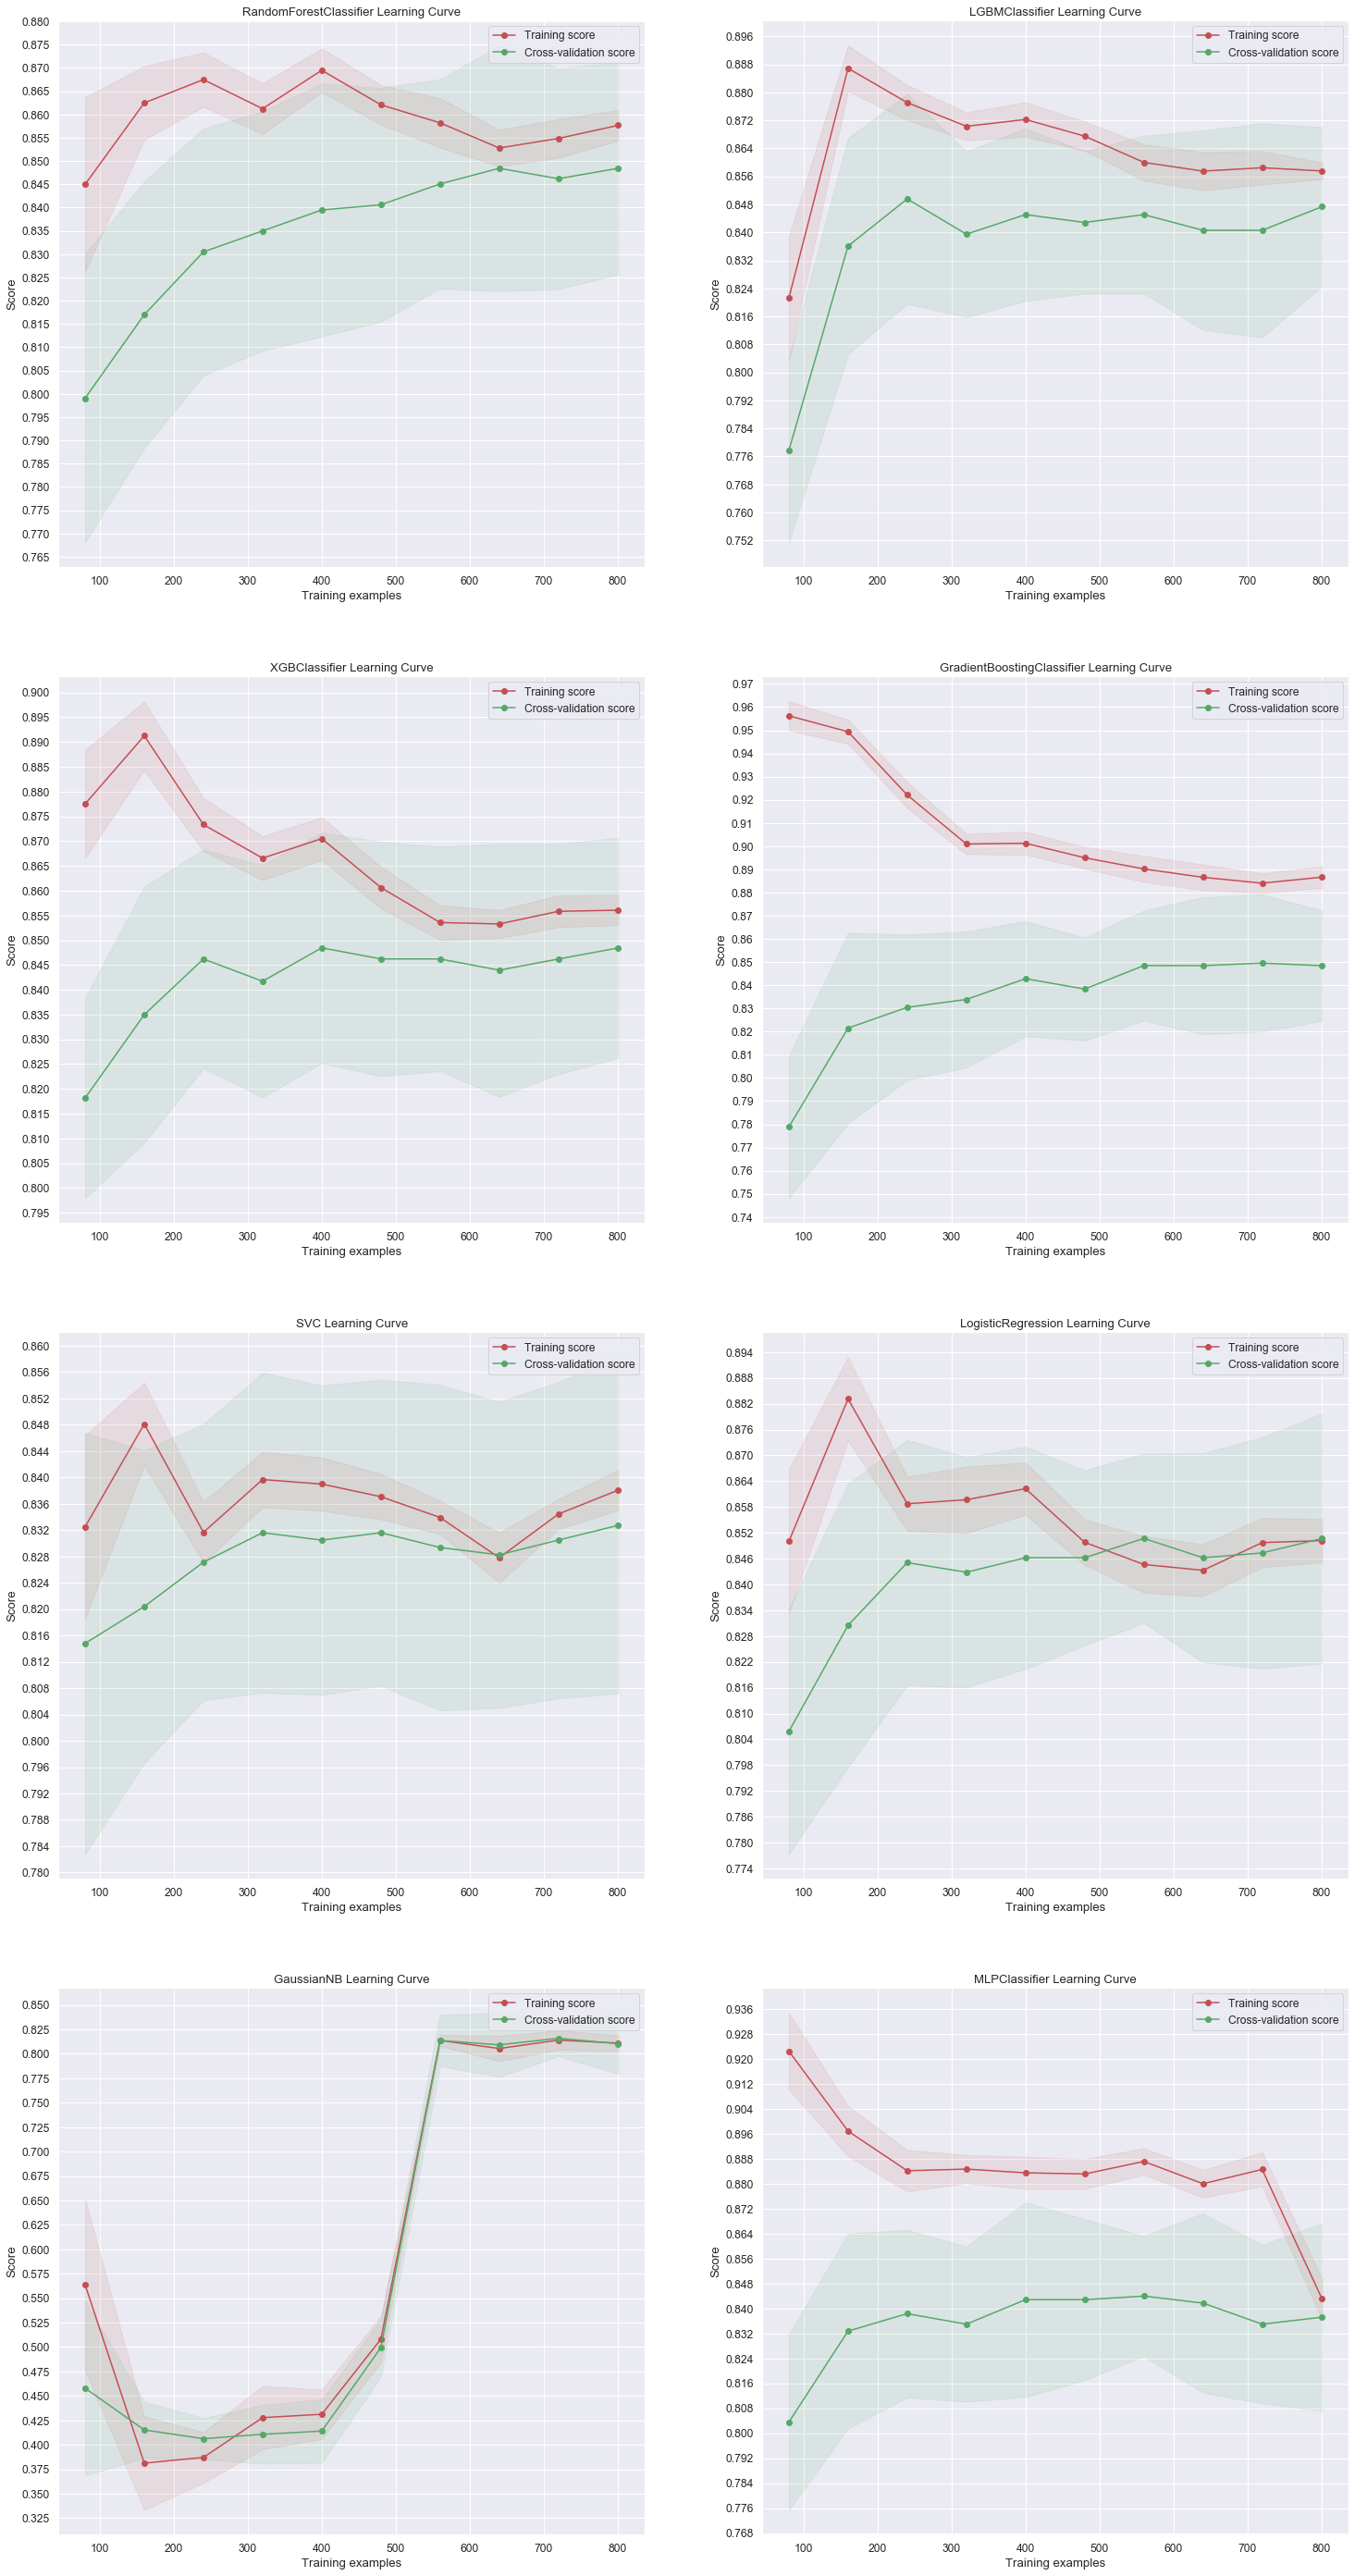

In [50]:
plot_learning_curve(estimators,
                    X,
                    y,
                    ylim=None,
                    cv=cv,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

<a id="section31.1"></a>
# Feature Selection

<a id="section32"></a>
## Feature Importances

Alright we have couple features and they seem working well. But I feel like some of them are not that important, I also want to reduce dimensions(features) in next chapters to gain new insights anyways. Luckly we have couple decision trees based models so we can use them to visualize feature importances. So... Let's get going!

### [Back To Table of Contents](#toc_section)

In [51]:
def f_imp(estimators, X, y, bins):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        try:
            estimator.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(estimator.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{estimator.__class__.__name__} Feature Impotances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()

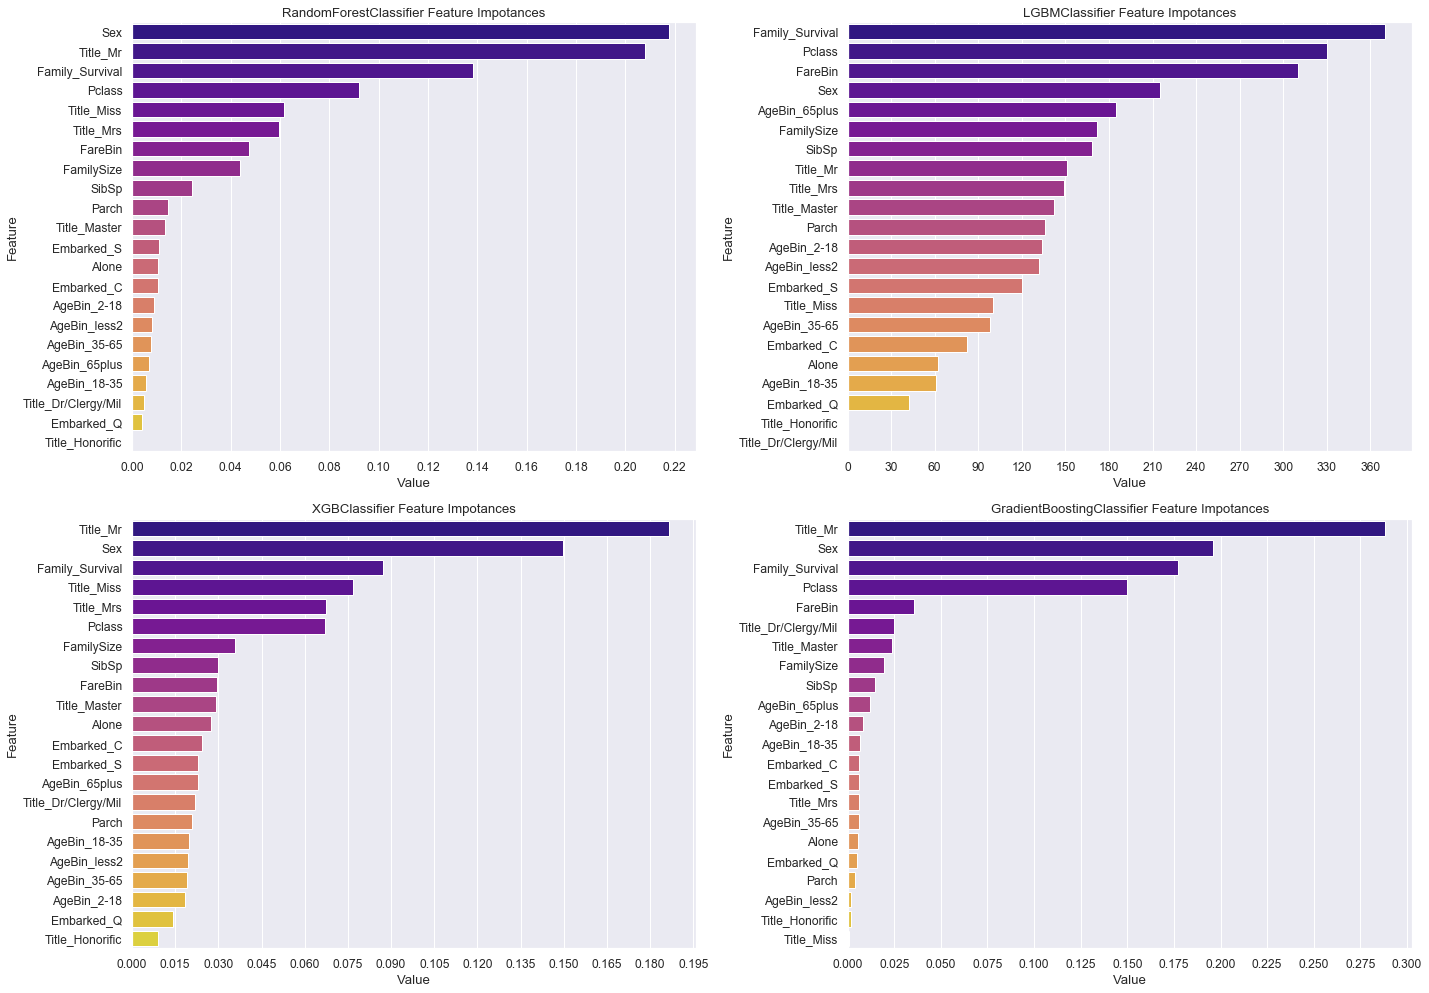

In [52]:
f_imp(estimators, X, y, 14)

<a id="section33"></a>
# Decision Trees
Since we were talking about decision tree based models I wanted to visualize how they work. For that I'm going to choose random forest classifier. RF has multiple decision trees in it, we clas display them all but I think first one should be enough for this notebook. You can learn more about decision tree plotting in this great notebook [here](https://www.kaggle.com/willkoehrsen/visualize-a-decision-tree-w-python-scikit-learn). 

You can see the tree is somewhat matching our feature importances ranking just above, again this is just for gaining some knowledge and you might not need it for the competition...

### [Back To Table of Contents](#toc_section)

In [53]:
# Train
rf.fit(X, y)
# Extract first tree from random forest
estimator = rf.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['Not Survived','Survived'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in python
plt.figure(figsize = (40, 20))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

<a id="section34"></a>
# Feature Selection by Recursive Feature Elimination

Again a part where my main motivation is learning and applying what I know. Here I'm gonna reduce dimensionality with two sklearn tools. First one is recursive feature elimination (RFE). The goal of RFE is to select features by recursively considering smaller and smaller sets of features. I'm going to prune half of the features we have, again this is just for experience and might not be needed for Titanic competition.

### [Back To Table of Contents](#toc_section)

In [ ]:
def f_selector(X, y, est, features):
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.4,
                                                          random_state=42)

    # Create the RFE with a LogisticRegression estimator and 4 features to select
    rfe = RFE(estimator=est, n_features_to_select=features, verbose=1)

    # Fit the eliminator to the data
    rfe.fit(X_train, y_train)

    # Print the features and their ranking (high = dropped early on)
    print(dict(zip(X.columns, rfe.ranking_)))

    # Print the features that are not eliminated
    print(X.columns[rfe.support_])

    # Calculates the test set accuracy
    acc = accuracy_score(y_valid, rfe.predict(X_valid))
    print("{0:.1%} accuracy on test set.".format(acc))
    X_red = X[X_train.columns[rfe.support_].to_list()]
    X_te_red = X_test[X_train.columns[rfe.support_].to_list()]
    return X_red, X_te_red

**Here we pruned half of the features we have, what left there is more important features like:**

'Pclass', 'Sex', 'SibSp', 'Family_Survival', 'FamilySize', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'FareBin'

In [ ]:
X_sel, X_test_sel = f_selector(X, y, rf, 11)

<a id="section35"></a>
# Dimension Reduction by Principal Component Analysis

Given a collection of points in two, three, or higher dimensional space, a "best fitting" line can be defined as one that minimizes the average squared distance from a point to the line. The next best-fitting line can be similarly chosen from directions perpendicular to the first. Repeating this process yields an orthogonal basis in which different individual dimensions of the data are uncorrelated. These basis vectors are called principal components, and several related procedures principal component analysis (PCA).

**Again with this we're reducing our models dimensions to 2, so we can plot decision regions. Like previous steps I'm doing this to get experience what can we do with PCA.**

### [Back To Table of Contents](#toc_section)

In [ ]:
# Build the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=2)),
])

# Fit the pipeline to the training data
X_sel_red = pipe.fit_transform(X_sel)
X_test_sel_red = pipe.transform(X_test_sel)

In [ ]:
def dec_regs(X, y, estimators):
    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(20, 40))

    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        estimator.fit(X, y.values)
        plot_decision_regions(X, y.values, clf=estimator,colors='#e00d14,#3ca02c',markers='x+', ax=ax)
        ax.set(title=f'Reg {estimator.__class__.__name__}')

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles,
                  ['Not Survived', 'Survived'],
                  framealpha=0.3, scatterpoints=1)

    plt.show()

- The code below is edited version of [this example from sklearn official page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) I really enjoyed while tinkering it, kudos to creators!

In [ ]:
def prob_reg(X, y):
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(20, 40))
    h = .02
    i = 1

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X_sel_red[:, 0].min() - .5, X_sel_red[:, 0].max() + .5
    y_min, y_max = X_sel_red[:, 1].min() - .5, X_sel_red[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdYlGn
    cm_bright = ListedColormap(['#e00d14', '#3ca02c'])
    ax = plt.subplot(5, 2, i)

    # Iterate over estimators
    for clf in estimators:
        ax = plt.subplot(math.ceil(len(estimators) / 2), 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        g = ax.scatter(X_train[:, 0],
                       X_train[:, 1],
                       c=y_train,
                       cmap=cm_bright,
                       edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap=cm_bright,
                   edgecolors='k',
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

        ax.set_title(clf.__class__.__name__)
        #ax.text(xx.max() - .3,
        #        yy.min() + .3, (f'Score:{score:.2f}'),
        #        size=15,
        #        horizontalalignment='right')

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        plt.legend(handles=g.legend_elements()[0],
                   labels=['Not Survived', 'Survived'],
                   framealpha=0.3,
                   scatterpoints=1)

        i += 1

    plt.tight_layout()
    plt.show()

<a id="section36"></a>
# Plotting Decision Boundaries

I just wanted to visualise how different models act on given 2D data. I can say that good fitting models produced similar results with small differences. I take this as a good theoretical information...

### [Back To Table of Contents](#toc_section)

In [ ]:
dec_regs(X_sel_red, y, estimators)

<a id="section37"></a>
# Plotting Decision Regions

Wanted to add this version including probabilities too, this one adds new vision to decision regions and worth inspecting. We can see how sure are the models on deciding and also giving hints about how complex model is. This one still experimental for me and may need to be improved, I'd be grateful for your feedback!

### [Back To Table of Contents](#toc_section)

In [ ]:
prob_reg(X_sel_red, y)

<a id="sectioncv"></a>
## Reduced Dimension Model Results with Cross-Validation

Hmm, it seems our feature selection/extractions reduced our overall accuracy around 5% with some overfitting models like GradientBoostingClassifier and RandomForestClassifier. I might try to tune them again but it's seems not needed for now...

### [Back To Table of Contents](#toc_section)

In [ ]:
pca_models = model_check(X_sel_red, y, estimators, cv)
display(pca_models.style.background_gradient(cmap='summer_r'))

In [ ]:
# Plotting model performances
model_barplot(pca_models, 24)

<a id="sectionlst"></a>
#  Submission

In [ ]:
rand_model_full_data = rf.fit(X, y)
print(accuracy_score(y, rand_model_full_data.predict(X)))
y_pred = rand_model_full_data.predict(X_test)

In [ ]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test_df['PassengerId']
submission_df['Survived'] = y_pred
submission_df.to_csv('submission.csv', header=True, index=False)
submission_df.head(10)

# Some last words

**I'm still a beginner and want to improve myself in every way I can. So if you have any ideas to feedback please let me know in comments, and if you liked my work please don't forget to vote, thank you!**

### [Back To Table of Contents](#toc_section)
